# FusionDB reactor browser

Lists all reactors side by side (one column per reactor) with every available field, including derived values. Columns with warnings are highlighted in yellow; mismatches beyond the 1% tolerance are highlighted in red (red overrides yellow). Warning messages are echoed below the table.
from fusdb.reactors_class import relations_for  # dynamic relation access


In [1]:
from pathlib import Path
import numbers
import re
import time
import warnings
import cProfile
import pstats
import sys
def find_repo_root(start: Path) -> Path:
    for path in (start, *start.parents):
        if (path / 'reactors').is_dir() and (path / 'src' / 'fusdb').is_dir():
            return path
    return start
root = find_repo_root(Path.cwd())
src_path = str(root / 'src')
if src_path not in sys.path:
    sys.path.insert(0, src_path)
import pandas as pd  # Pandas is required for styling
import yaml
import sympy as sp
from fusdb.loader import (
    OPTIONAL_METADATA_FIELDS,
    REQUIRED_FIELDS,
    find_reactor_dirs,
    load_reactor_yaml,
)
from fusdb.reactor_util import variable_aliases
from fusdb.relation_util import REL_TOL_DEFAULT


In [2]:
pd.set_option("display.max_rows", None)
pd.set_option("display.max_columns", None)
pd.set_option("display.width", None)
PROFILE_TOP = 25
profiler = cProfile.Profile()
profiler.enable()
# Load reactors and capture warnings per reactor and field
reactors = {}
computed_flags: dict[tuple[str, str], bool] = {}
input_status: dict[tuple[str, str], str] = {}
warning_messages: dict[str, list[str]] = {}
explicit_params_by_reactor: dict[str, set[str]] = {}
reserved_keys = set(REQUIRED_FIELDS + OPTIONAL_METADATA_FIELDS)
aliases = variable_aliases()
def is_explicit_param(value: object) -> bool:
    if isinstance(value, dict):
        return value.get("value") is not None
    return value is not None
def log(msg: str) -> None:
    print(msg)
def numeric_value(value: object) -> float | None:
    if isinstance(value, sp.Expr):
        if value.free_symbols:
            return None
        evaluated = value.evalf(chop=True)
        try:
            return float(evaluated)
        except (TypeError, ValueError):
            return None
    if isinstance(value, numbers.Real) and not isinstance(value, bool):
        return float(value)
    return None
def to_display_value(value: object) -> object:
    if isinstance(value, sp.Expr):
        if not value.free_symbols:
            evaluated = value.evalf(chop=True)
            try:
                return float(evaluated)
            except (TypeError, ValueError):
                try:
                    complex_val = complex(evaluated)
                except (TypeError, ValueError):
                    return value
                tol = 1e-12 * max(1.0, abs(complex_val.real))
                if abs(complex_val.imag) <= tol:
                    return float(complex_val.real)
            return value
    return value
def format_sci(value: object) -> str:
    if isinstance(value, numbers.Real) and not isinstance(value, bool):
        if value != 0 and (abs(value) >= 1e3 or abs(value) <= 1e-3):
            return f"{value:.2e}"
    if value is None:
        return ""
    return str(value)
def classify_input_status(input_val: object, solved_val: object, tol: float) -> str:
    input_num = numeric_value(input_val)
    solved_num = numeric_value(solved_val)
    if input_num is None or solved_num is None:
        return "red"
    delta = solved_num - input_num
    if delta == 0:
        return "green"
    scale = max(abs(input_num), abs(solved_num), 1.0)
    if abs(delta) <= tol * scale:
        return "yellow"
    return "red"
log(f"Loading reactors from {root.resolve()}")
for reactor_dir in find_reactor_dirs(root):
    path = reactor_dir / 'reactor.yaml'
    log(f"Loading {reactor_dir.name}...")
    start = time.perf_counter()
    raw_data = yaml.safe_load(path.read_text()) or {}
    parse_elapsed = time.perf_counter() - start
    explicit_params = set()
    if isinstance(raw_data, dict):
        explicit_params = {
            aliases.get(key, key)
            for key, value in raw_data.items()
            if key not in reserved_keys and is_explicit_param(value)
        }
    log(f"  Parsed YAML in {parse_elapsed:.2f}s; {len(explicit_params)} explicit params")
    start = time.perf_counter()
    with warnings.catch_warnings(record=True) as caught:
        warnings.simplefilter('always')
        reactor = load_reactor_yaml(path)
    load_elapsed = time.perf_counter() - start
    log(f"  Loaded reactor in {load_elapsed:.2f}s; {len(caught)} warnings")
    reactors[reactor.id] = reactor
    if reactor.relations_used:
        log("  Relations used:")
        for tags, rel in reactor.relations_used:
            tag_label = ", ".join(tags) if tags else "untagged"
            output_name = rel.variables[0] if rel.variables else "?"
            log(f"    - {rel.name} ({output_name}) [{tag_label}]")
    explicit_params_by_reactor[reactor.id] = explicit_params
    for key in reactor.parameters:
        computed_flags[(key, reactor.id)] = key not in explicit_params
    messages = [str(w.message) for w in caught]
    warning_messages[reactor.id] = messages
profiler.disable()
pstats.Stats(profiler).sort_stats("cumtime").print_stats(PROFILE_TOP)
metadata_fields = REQUIRED_FIELDS + OPTIONAL_METADATA_FIELDS
parameter_names = sorted({key for reactor in reactors.values() for key in reactor.parameters.keys()}, key=lambda name: (name.lower(), name))
field_names = metadata_fields + parameter_names
log(f"Building table: {len(metadata_fields)} metadata fields, {len(parameter_names)} parameters")
# Build a DataFrame with metadata + parameter rows
parameter_set = set(parameter_names)
table_data: dict[str, list[object]] = {}
for rid, reactor in sorted(reactors.items()):
    values: list[object] = []
    explicit_params = explicit_params_by_reactor.get(rid, set())
    for name in field_names:
        if name in parameter_set:
            solved_val = to_display_value(reactor.parameters.get(name))
            if name in explicit_params:
                input_val = to_display_value(reactor.input_parameters.get(name))
                tol = reactor.parameter_tolerances.get(name, REL_TOL_DEFAULT)
                status = classify_input_status(input_val, solved_val, tol)
                input_status[(name, rid)] = status
                input_str = format_sci(input_val)
                if status == "red":
                    solved_str = format_sci(solved_val)
                    values.append(f"{input_str} (<span style='text-decoration: underline;'>{solved_str}</span>)")
                else:
                    values.append(input_str)
            else:
                values.append(format_sci(solved_val))
        else:
            values.append(format_sci(to_display_value(getattr(reactor, name, None))))
    table_data[rid] = values
df = pd.DataFrame(table_data, index=field_names)
def style_cells(data: pd.DataFrame) -> pd.DataFrame:
    styles = pd.DataFrame('', index=data.index, columns=data.columns)
    for field in styles.index:
        for rid in styles.columns:
            parts = []
            if computed_flags.get((field, rid)):
                parts.append('text-decoration: underline;')
            status = input_status.get((field, rid))
            if status == 'red':
                parts.append('color: #b30000; font-weight: 600;')
            elif status == 'yellow':
                parts.append('color: #b58900;')
            elif status == 'green':
                parts.append('color: #0a7d2a;')
            styles.loc[field, rid] = ' '.join(parts)
    return styles
styled = df.style.apply(style_cells, axis=None)
styled = styled.format(escape=None)
display(styled)
# Show warnings below the table
for rid, msgs in warning_messages.items():
    if not msgs:
        continue
    print(f'Warnings for {rid}:')
    for msg in msgs:
        print(f' - {msg}')


Loading reactors from /home/alessmor/Scrivania/fusdb
Loading ARC_2015...
  Parsed YAML in 0.02s; 35 explicit params
  Loaded reactor in 6.28s; 21 warnings
  Relations used:
    - tau_E_hubbard_nominal (tau_E) [confinement, tokamak, I-mode]
    - Thermal stored energy (W_th) [plasma]
    - Energy confinement time (tau_E) [plasma]
    - Major radius (R) [geometry]
    - Aspect ratio (A) [geometry]
    - Elongation (kappa) [geometry]
    - Elongation 95% (kappa) [geometry, tokamak]
    - Triangularity 95% (delta) [geometry, tokamak]
    - IPB elongation from volume (kappa_ipb) [geometry]
    - Tokamak volume (V_p) [geometry, tokamak]
    - Tokamak surface (S_p) [geometry, tokamak]
    - Troyon beta limit (beta_limit) [plasma, tokamak]
    - Greenwald density limit (n_GW) [plasma, tokamak]
    - Greenwald density fraction (f_GW) [plasma, tokamak]
    - Electron density from volume-averaged density (n_e) [plasma]
    - Electron density from ion fractions (n_e) [plasma]
    - Deuterium densi

,ARC_2015,DEMO_2018,Hammir2024,InfinityTwo2025,STEP2024EBCC,Stellaris2025
id,ARC_2015,DEMO_2018,Hammir2024,InfinityTwo2025,STEP2024EBCC,Stellaris2025
name,ARC 2015,EU-DEMO 2018,Hammir 2024,INFINITY TWO 2025,STEP 2024 EB-CC,Stellaris 2025 - Point A
reactor_configuration,compact tokamak,tokamak,spherical tokamak,stellarator,spherical tokamak,stellarator
organization,MIT,EUROFUSION,Realta,TypeOne Energy,UKAEA,Proxima
reactor_family,ARC,DEMO,,,STEP,
country,USA,EUU,,,GBR,
site,,,,,,
design_year,2.02e+03,2.02e+03,2.02e+03,2.02e+03,2.02e+03,2.02e+03
doi,10.1016/j.fusengdes.2015.07.008,10.1016/j.fusengdes.2022.113080,10.1088/1741-4326/ad3fcb,10.1017/S0022377825000364,10.1088/1741-4326/ad6ea2,10.1016/j.fusengdes.2025.114868
notes,Conceptual compact tokamak from MIT.,EU-DEMO Physics Baseline 2018,,,Refers to EC+EBW heating scenario with Conservative Confinement conditions,


Warnings for ARC_2015:
 - ARC_2015: ion fractions not provided; assuming 50-50 D-T with no impurities.
 - ARC_2015: inferred n_i from n_avg for composition with missing fractions treated as zero.
 - ARC_2015: n_i not provided; inferred from n_avg for composition.
 - ARC_2015: n_la not provided; will fall back to n_avg when available.
 - tau_E_hubbard_nominal violates relation (missing values for: dnla20)
 - Major radius violates relation (missing values for: R_max, R_min)
 - Elongation violates relation (missing values for: Z_max, Z_min, R_max, R_min)
 - Triangularity 95% violates relation (residual=-5.329070518200751e-15, tol=0.12318438079176951, constraints violated)
 - Tokamak volume violates relation (residual=-3.694822225952521e-13, tol=1.53, constraints violated)
 - Tokamak surface violates relation (residual=0.0, tol=63.662009078951115, constraints violated)
 - Fusion triple product violates relation (missing values for: n_i_tau_E_T_i, n_i_peak, T_i_peak)
 - Physics gain factor 

In [3]:
ARC = load_reactor_yaml('/home/alessmor/Scrivania/fusdb/reactors/ARC_2015/reactor.yaml')
DEMO = load_reactor_yaml('/home/alessmor/Scrivania/fusdb/reactors/DEMO_2018/reactor.yaml')
STEP = load_reactor_yaml('/home/alessmor/Scrivania/fusdb/reactors/STEP_2024/reactor.yaml')
Stellaris = load_reactor_yaml('/home/alessmor/Scrivania/fusdb/reactors/STELLARIS/reactor.yaml')

/home/alessmor/Scrivania/fusdb/src/fusdb/registry/reactor_defaults.py:56: UserWarning: ARC_2015: ion fractions not provided; assuming 50-50 D-T with no impurities.
  warn_func(
/home/alessmor/Scrivania/fusdb/src/fusdb/registry/reactor_defaults.py:110: UserWarning: ARC_2015: inferred n_i from n_avg for composition with missing fractions treated as zero.
  warn_func(
/home/alessmor/Scrivania/fusdb/src/fusdb/registry/reactor_defaults.py:117: UserWarning: ARC_2015: n_i not provided; inferred from n_avg for composition.
  warn_func(
/home/alessmor/Scrivania/fusdb/src/fusdb/registry/reactor_defaults.py:159: UserWarning: ARC_2015: n_la not provided; will fall back to n_avg when available.
  warn_func(
/home/alessmor/Scrivania/fusdb/src/fusdb/relation_class.py:190: UserWarning: tau_E_hubbard_nominal violates relation (missing values for: dnla20)
  self.warn_sink(msg, UserWarning)
/home/alessmor/Scrivania/fusdb/src/fusdb/relation_class.py:190: UserWarning: Major radius violates relation (missin

In [4]:
# print Vplasma, Tavg, navg, tauE, fusion power and auxiliary power for the reactors
for reactor in [ARC, DEMO, STEP, Stellaris]:
    Vplasma = reactor.parameters.get('V_p')
    Tavg = reactor.parameters.get('T_avg')
    navg = reactor.parameters.get('n_avg')
    tauE = reactor.parameters.get('tau_E')
    P_fusion = reactor.parameters.get('P_fus')
    P_aux = reactor.parameters.get('P_aux')
    print(f"{reactor.id}: V_plasma={format_sci(Vplasma)}, T_avg={format_sci(Tavg)}, n_avg={format_sci(navg)}, tau_E={format_sci(tauE)}, P_fusion={format_sci(P_fusion)}, P_auxiliary={format_sci(P_aux)}")

ARC_2015: V_plasma=153.0, T_avg=14.0, n_avg=1.30e+20, tau_E=0.64, P_fusion=4.26e+08, P_auxiliary=
DEMO_2018: V_plasma=2.57e+03, T_avg=12.49, n_avg=8.06e+19, tau_E=1.9081680999422492, P_fusion=2.24e+09, P_auxiliary=
STEP2024EBCC: V_plasma=824.7120087781971, T_avg=9.69, n_avg=1.64e+20, tau_E=0.9326250104698844, P_fusion=1.64e+09, P_auxiliary=1.30e+08
Stellaris2025: V_plasma=425.0, T_avg=12.0, n_avg=3.17e+20, tau_E=1.46, P_fusion=3.27e+09, P_auxiliary=5.00e+07


Skipping Hammir2024: Sauter cross-section requires numeric R and a
Skipping InfinityTwo2025: Cross-section plotting is not implemented for 'stellarator'
Skipping Stellaris2025: Cross-section plotting is not implemented for 'stellarator'


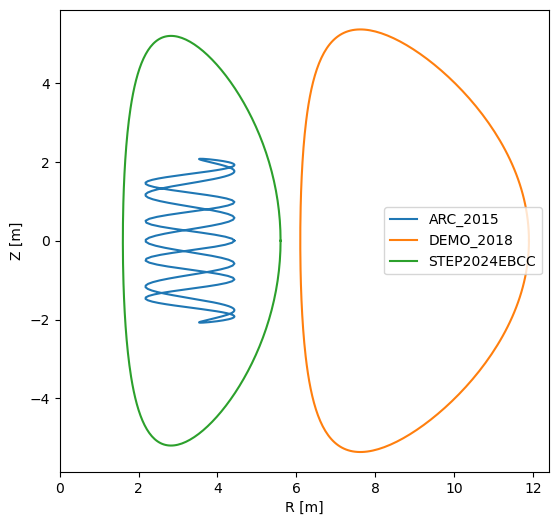

In [5]:
# plot plasma cross-sections (Sauter geometry)
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(7, 6))
max_outer = 0.0
max_z = 0.0

for reactor in reactors.values():
    try:
        reactor.plot_cross_section(ax=ax, label=reactor.id)
        line = ax.lines[-1]
        r_vals = line.get_xdata()
        z_vals = line.get_ydata()
    except (ValueError, NotImplementedError) as exc:
        print(f"Skipping {reactor.id}: {exc}")
        continue
    try:
        outer = float(reactor.R) + float(reactor.a)
    except (TypeError, ValueError, AttributeError):
        outer = max(r_vals)
    max_outer = max(max_outer, outer)
    max_z = max(max_z, max(abs(z) for z in z_vals))

ax.set_aspect('equal', adjustable='box')
ax.set_xlim(0, max_outer+0.5)
ax.set_ylim(-max_z-0.5, max_z+0.5)
ax.set_xlabel('R [m]')
ax.set_ylabel('Z [m]')
ax.legend()
plt.show()
